In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import os
import subprocess

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

In [2]:
df = {}
df['s'] = uproot.lazy("/data/pku/home/licq/cH/zz_v2/selection/fitspace/std/HC_4FSFxFx.root")
df['b'] = uproot.lazy("/data/pku/home/licq/cH/zz_v2/selection/fitspace/std/ggH.root")
for s in 'sb':
    df[s] = df[s][df[s].jet_cand_pt > 0]

hist = {}
arr = {}
err = {}
for s in 'sb':
    hist[s]= bh.Histogram(
        bh.axis.Regular(100, 0, 1),
        bh.axis.Regular(100, 0, 1),
        bh.axis.Regular(100, 0, 1),
        storage=bh.storage.Weight()
    )
    hist[s].fill(df[s].jet_cand_ParticleNet_CvsL, df[s].jet_cand_ParticleNet_CvsB, df[s].bdt_1j, weight=df[s].weight)
    arr[s] = hist[s].values()
    err[s] = hist[s].variances()
    for o in [arr, err]:
        o[s] = np.cumsum(o[s][:, :, ::-1], axis=2)[:, :, ::-1]
        o[s] = np.cumsum(o[s][:, ::-1, :], axis=1)[:, ::-1, :]
        o[s] = np.cumsum(o[s][::-1, :, :], axis=0)[::-1, :, :]

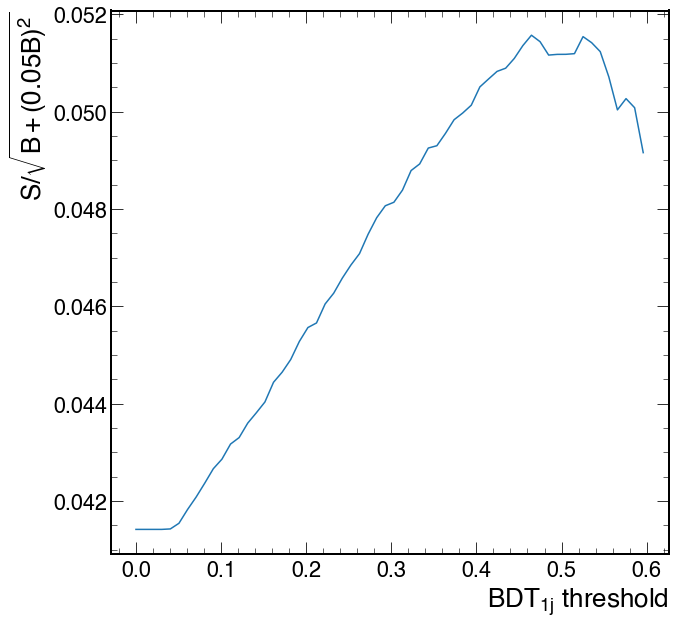

In [5]:
z = arr['s'] / np.sqrt(arr['b'] + (0.05*arr['b'])**2 + 1e-20)

f, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.linspace(0, 1, 100)[:60], np.max(np.max(z, axis=0), axis=0)[:60])
ax.set_xlabel(r'$BDT_{1j}$ threshold'); ax.set_ylabel(r'$S/\sqrt{B + (0.05B)^2}$')
plt.savefig("../plots/histo_230216/optim_cut_1j.pdf")

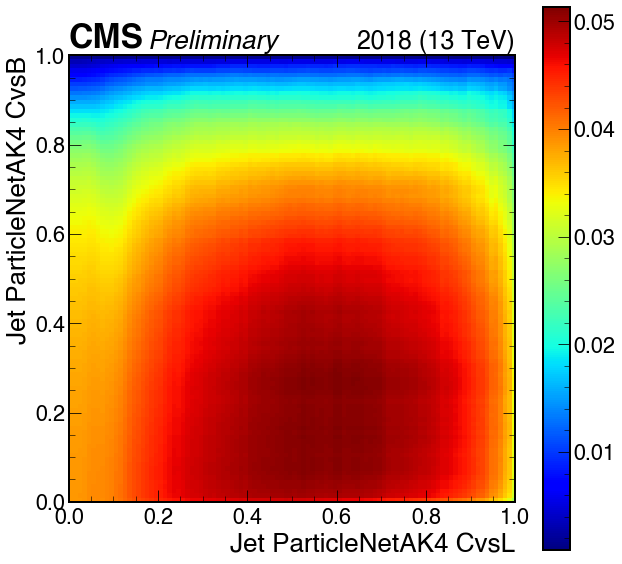

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif')
im = ax.imshow(
    z[:, ::-1, 45].T, 
    # norm=mpl.colors.LogNorm(), 
    interpolation='nearest', extent=[0, 1, 0, 1], cmap=plt.cm.jet)
f.colorbar(im, ax=ax)
ax.set_xlabel('Jet ParticleNetAK4 CvsL'); ax.set_ylabel('Jet ParticleNetAK4 CvsB')
plt.savefig("../plots/histo_230216/scan_1j.pdf")

In [68]:
df[s].sv_cand_ParticleNet_bb

<Array [0.00107, 0.000228, ... 0.000488] type='12918 * float32'>

In [7]:
df = {}
df['s'] = uproot.lazy("/data/pku/home/licq/cH/zz_v2/selection/fitspace/std/HC_4FSFxFx.root")
df['b'] = uproot.lazy("/data/pku/home/licq/cH/zz_v2/selection/fitspace/std/ggH.root")
for s in 'sb':
    df[s] = df[s][(df[s].jet_cand_pt < 0) & (df[s].sv_cand_pt > 0)]

hist = {}
arr = {}
err = {}
for s in 'sb':
    hist[s]= bh.Histogram(
        bh.axis.Regular(100, 0, 1),
        bh.axis.Regular(100, 0, 1),
        bh.axis.Regular(100, 0, 1),
        storage=bh.storage.Weight()
    )
    hist[s].fill(
        (df[s].sv_cand_ParticleNet_c + df[s].sv_cand_ParticleNet_cc)/(df[s].sv_cand_ParticleNet_c + df[s].sv_cand_ParticleNet_cc + df[s].sv_cand_ParticleNet_unmat),
        (df[s].sv_cand_ParticleNet_c + df[s].sv_cand_ParticleNet_cc)/(df[s].sv_cand_ParticleNet_c + df[s].sv_cand_ParticleNet_cc + df[s].sv_cand_ParticleNet_b + df[s].sv_cand_ParticleNet_bb),
        df[s].bdt_0j,
        weight=df[s].weight)
    arr[s] = hist[s].values()
    err[s] = hist[s].variances()
    for o in [arr, err]:
        o[s] = np.cumsum(o[s][:, :, ::-1], axis=2)[:, :, ::-1]
        o[s] = np.cumsum(o[s][:, ::-1, :], axis=1)[:, ::-1, :]
        o[s] = np.cumsum(o[s][::-1, :, :], axis=0)[::-1, :, :]

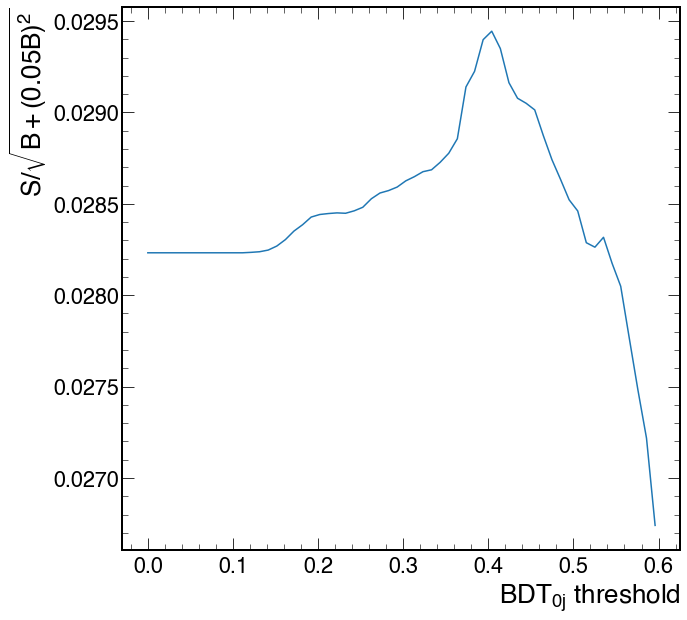

In [10]:
z = arr['s'] / np.sqrt(arr['b'] + (0.05*arr['b'])**2 + 1e-20)

f, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.linspace(0, 1, 100)[:60], np.max(np.max(z[:, :80, :], axis=0), axis=0)[:60])
ax.set_xlabel(r'$BDT_{0j}$ threshold'); ax.set_ylabel(r'$S/\sqrt{B + (0.05B)^2}$')
plt.savefig("../plots/histo_230216/optim_cut_0j.pdf")

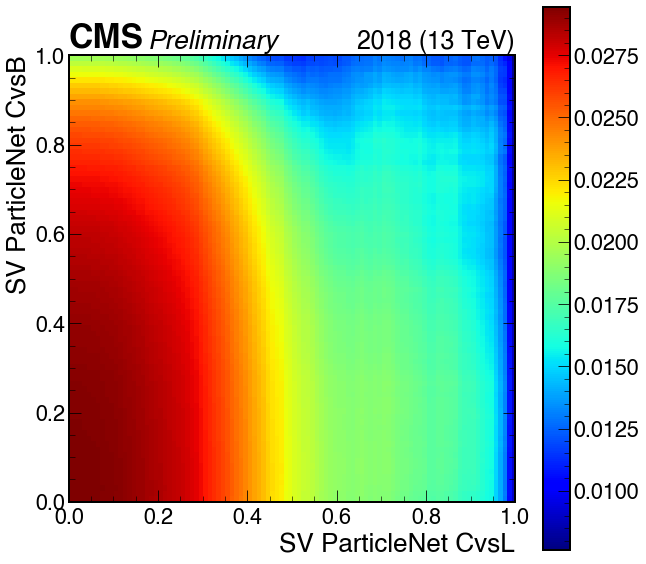

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif')
im = ax.imshow(
    z[:, 80::-1, 40].T, 
    # norm=mpl.colors.LogNorm(), 
    interpolation='nearest', extent=[0, 1, 0, 1], cmap=plt.cm.jet)
f.colorbar(im, ax=ax)
ax.set_xlabel('SV ParticleNet CvsL'); ax.set_ylabel('SV ParticleNet CvsB')
plt.savefig("../plots/histo_230216/scan_0j.pdf")

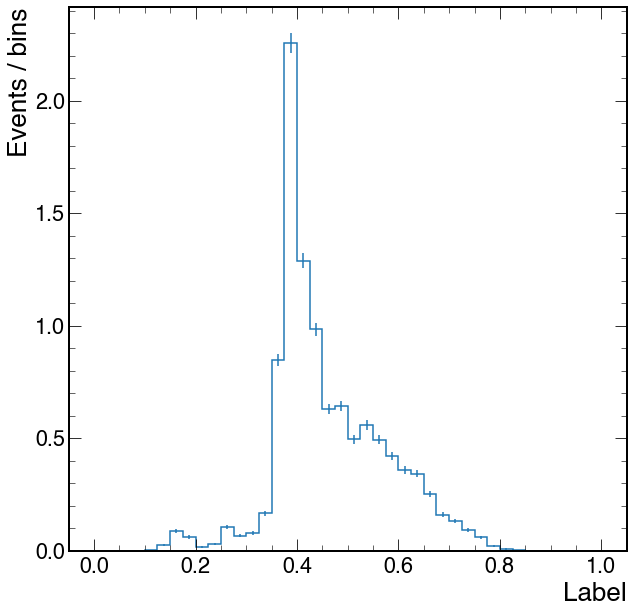

In [73]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

hist.fill(df['b'].bdt_0j, weight=df['b'].weight)

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);